In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import setuptools
%matplotlib inline
%load_ext cython

In [2]:
def rolling_max_drawdown(sr):
    for i in sr:
        j = np.argmax(sr)
        val = (sr[-1] - sr[j])
        if  val >= 0 :
            return 0
        else:
            return val

In [3]:
def max_drawdown_old(sr):
    '''
    复杂度 O(N^2)
    INPUT:
        iterable obj: (1dim)
    OUTPUT:
        maxdd: 最大回撤，为[-inf,0]
        start: 最大回撤起始点下标
        end:   最大回撤终止点下标
    '''
    if None in sr:
        raise TypeError("Input has None:(Python type none).")
    if type(sr).__name__ == 'DataFrame':
        raise TypeError("Input Type must in [python.list/pandas.Series/numpy.1darray]")
    if len(sr) <= 1:
        return 0,0,0
    if type(sr).__name__ == 'Series':
        sr = sr.values
    if any(np.isinf(sr)):
        return np.inf,0,0
        
    if any(np.isnan(sr)):
        mean = np.nanmean(sr)# use mean fill nan
        sr[np.isnan(sr)] = mean
    maxdds = []
    starts = []
    ends = []
    for i in range(1,len(sr)):
        j = np.argmax(sr[:i])#  little list maybe slow 
        
        val = (sr[i] - sr[j])/sr[j]
        if  val >= 0 :
            maxdds.append(0)
            starts.append(j)
            ends.append(i)
        else:
            maxdds.append(val)
            starts.append(j)
            ends.append(i)
    maxdd = min(maxdds)
    maxddidx = maxdds.index(maxdd)
    if maxdd == 0:
        return 0,0,0
    return maxdd,starts[maxddidx],ends[maxddidx]



In [8]:
# %%cython 
# import numpy as np
# cimport numpy as np
# cimport cython

def max_drawdown(sr):
    '''
    复杂度 O(N^2)
    INPUT:
        iterable obj: (1dim)
    OUTPUT:
        maxdd: 最大回撤，为[-inf,0]
        start: 最大回撤起始点下标
        end:   最大回撤终止点下标
    '''
    if None in sr:
        raise TypeError("Input has None:(Python type none).")
    if type(sr).__name__ == 'DataFrame':
        raise TypeError("Input Type must in [python.list/pandas.Series/numpy.1darray]")
    if len(sr) <= 1:
        return 0,0,0
    if type(sr).__name__ == 'Series':
        sr = sr.values
    if any(np.isinf(sr)):
        return np.inf,0,0
        
    if any(np.isnan(sr)):
        mean = np.nanmean(sr)# use mean fill nan
        sr[np.isnan(sr)] = mean
        
#     cdef int maxdd_cur = 0
#     cdef int start_cur = 0
#     cdef int end_cur = 0
#     cdef int i = 0
#     cdef int j = 0
    
    for i in range(1,len(sr)):
        j = np.argmax(sr[:i])#  little list maybe slow 
        val = (sr[i] - sr[j])/sr[j]
        if  val >= 0 :
            pass
        else:
            if val < maxdd_cur:
                maxdd_cur = val
                start_cur = j
                end_cur = i
                
    maxdd = maxdd_cur
    istart = start_cur
    iend = end_cur
    if maxdd == 0:
        return 0,0,0
    return maxdd,istart,iend



In [9]:
sr  = pd.Series(np.array(1000*[1,2,3,4,5,4,5,6,7,8,9,10,8.5,8,7.5,8,9,8.5,8,7,6,5.5,6,7,8,9,6,6,7,8,9,12,8,15]))
maxdd,start,end = max_drawdown_old(sr)
print (maxdd,start,end)
%timeit  max_drawdown(sr) # too slow

0.933333333333 33 34
746 ms ± 56.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [12]:
sr  = pd.Series(np.array(1000*[1,2,3,4,5,4,5,6,7,8,9,10,8.5,8,7.5,8,9,8.5,8,7,6,5.5,6,7,8,9,6,6,7,8,9,12,8,15]))
maxdd,start,end = max_drawdown(sr)
print (maxdd,start,end)
%timeit  max_drawdown(sr) # too slow

-0.933333333333 33 34
704 ms ± 21.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [14]:
def max_drawdown(sr):
    if np.isnan(sr).all() or np.isinf(sr).all():
        return np.nan
    i = np.argmax(np.maximum.accumulate(sr) - sr) # end of the period
    j = np.argmax(sr[:i]) # start of period
    return abs(sr[i] - sr[j] )/abs(sr[j]),j,i
sr  = pd.Series(np.array(1000*[1,2,3,4,5,4,5,6,7,8,9,10,8.5,8,7.5,8,9,8.5,8,7,6,5.5,6,7,8,9,6,6,7,8,9,12,8,15]))
maxdd,start,end = max_drawdown(sr)
print (maxdd,start,end)
# plt.plot(sr)
# plt.plot(start,sr[start],'o')
# plt.plot(end,sr[end],'o')
%timeit  max_drawdown(sr) # too slow

/opt/anaconda/envs/py3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:57: FutureWarning: 'argmax' is deprecated. Use 'idxmax' instead. The behavior of 'argmax' will be corrected to return the positional maximum in the future. Use 'series.values.argmax' to get the position of the maximum now.
  return getattr(obj, method)(*args, **kwds)
/opt/anaconda/envs/py3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:57: FutureWarning: 'argmax' is deprecated. Use 'idxmax' instead. The behavior of 'argmax' will be corrected to return the positional maximum in the future. Use 'series.values.argmax' to get the position of the maximum now.
  return getattr(obj, method)(*args, **kwds)


0.933333333333 33 34
1.45 ms ± 47 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


/opt/anaconda/envs/py3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:57: FutureWarning: 'argmax' is deprecated. Use 'idxmax' instead. The behavior of 'argmax' will be corrected to return the positional maximum in the future. Use 'series.values.argmax' to get the position of the maximum now.
  return getattr(obj, method)(*args, **kwds)


660 µs ± 19.3 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


0.45 12.0 8.0


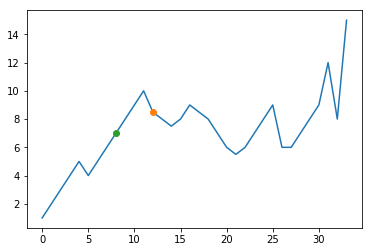

In [57]:
def max_drawdown(sr): 
    start = 0
    end = 0
    max_dd = 0
    is_down = False
    for index in range(len(sr)-1):
        try:
            if sr[index] > start:
                start = sr[index]
            if sr[index+1] >= sr[index]:#下一天上涨
                if not is_down:#之前没有下跌过
                    continue
                else:#之前下跌过
                    dd = float(start - end) / start
                    if dd > max_dd:
                        max_dd = dd
                    is_down = False
            else:#下一天下跌
                is_down = True
                end = sr[index+1]
        except:
            continue
    dd = float(start - end) / start
    if dd > max_dd:
        max_dd = dd

    return max_dd, start, end

sr  = pd.Series(np.array([1,2,3,4,5,4,5,6,7,8,9,10,8.5,8,7.5,8,9,8.5,8,7,6,5.5,6,7,8,9,6,6,7,8,9,12,8,15]))
maxdd,start,end = max_drawdown(sr)
print (maxdd,start,end)
plt.plot(sr)
plt.plot(start,sr[start],'o')
plt.plot(end,sr[end],'o')

-0.45 11 21


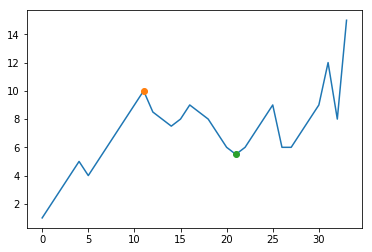

In [8]:
sr  = pd.Series(np.array([1,2,3,4,5,4,5,6,7,8,9,10,8.5,8,7.5,8,9,8.5,8,7,6,5.5,6,7,8,9,6,6,7,8,9,12,8,15]))
maxdd,start,end = max_drawdown(sr)
print (maxdd,start,end)
plt.plot(sr)
plt.plot(start,sr[start],'o')
plt.plot(end,sr[end],'o')

0 0 0


/opt/anaconda/envs/py3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:57: FutureWarning: 'argmax' is deprecated. Use 'idxmax' instead. The behavior of 'argmax' will be corrected to return the positional maximum in the future. Use 'series.values.argmax' to get the position of the maximum now.
  return getattr(obj, method)(*args, **kwds)


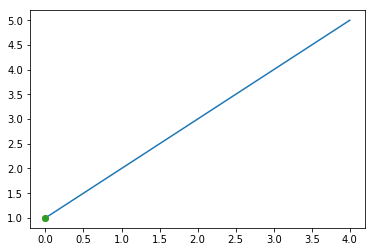

In [51]:
sr  = pd.Series(np.array([1,2,3,4,5]))
maxdd,start,end = max_drawdown(sr)
print (maxdd,start,end)
plt.plot(sr)
plt.plot(start,sr[start],'o')
plt.plot(end,sr[end],'o')

-0.375 0 3


/opt/anaconda/envs/py3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:57: FutureWarning: 'argmax' is deprecated. Use 'idxmax' instead. The behavior of 'argmax' will be corrected to return the positional maximum in the future. Use 'series.values.argmax' to get the position of the maximum now.
  return getattr(obj, method)(*args, **kwds)


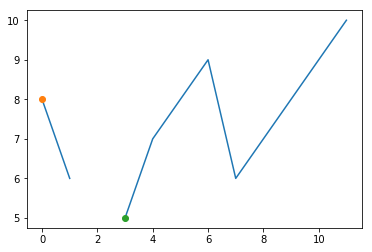

In [28]:
sr  = pd.Series(np.array([8,6,np.nan,5,7,8,9,6,7,8,9,10]))
maxdd,start,end = max_drawdown(sr)
plt.plot(sr)
plt.plot(start,sr[start],'o')
plt.plot(end,sr[end],'o')
print (maxdd,start,end)

-0.25 0 1


/opt/anaconda/envs/py3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:57: FutureWarning: 'argmax' is deprecated. Use 'idxmax' instead. The behavior of 'argmax' will be corrected to return the positional maximum in the future. Use 'series.values.argmax' to get the position of the maximum now.
  return getattr(obj, method)(*args, **kwds)
/opt/anaconda/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in double_scalars
  # This is added back by InteractiveShellApp.init_path()


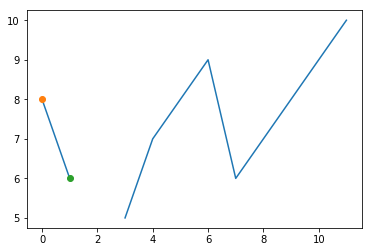

In [65]:
sr  = pd.Series(np.array([8,6,np.inf,5,7,8,9,6,7,8,9,10]))
maxdd,start,end = max_drawdown(sr)
plt.plot(sr)
plt.plot(start,sr[start],'o')
plt.plot(end,sr[end],'o')
print (maxdd,start,end)

True
-0.25 0 1


/opt/anaconda/envs/py3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:57: FutureWarning: 'argmax' is deprecated. Use 'idxmax' instead. The behavior of 'argmax' will be corrected to return the positional maximum in the future. Use 'series.values.argmax' to get the position of the maximum now.
  return getattr(obj, method)(*args, **kwds)
/opt/anaconda/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in double_scalars
  if sys.path[0] == '':


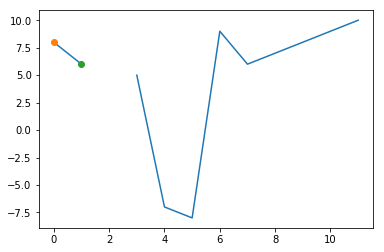

In [73]:
sr  = pd.Series(np.array([8,6,np.inf,5,-7,-8,9,6,7,8,9,10]))
maxdd,start,end = max_drawdown(sr)
plt.plot(sr)
plt.plot(start,sr[start],'o')
plt.plot(end,sr[end],'o')
print (maxdd,start,end)

(-15.0, 4, 5)


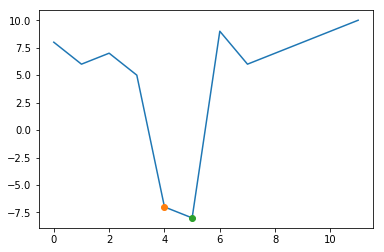

In [12]:
sr  = np.array([8,6,7,5,-7,-8,9,6,7,8,9,10],dtype=np.float32)
maxdd,start,end = max_drawdown(sr)
print (maxdd,start,end)
plt.plot(sr)
plt.plot(start,sr[start],'o')
plt.plot(end,sr[end],'o')


In [13]:
sr  = np.array([8,6,7,5,-7,-8,9,6,7,8,9,10])
%timeit  max_drawdown(sr)


46.3 µs ± 3.64 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [16]:
sr  = np.array([8,6,7,5,-7,-8,9,6,7,8,9,10])
%timeit  max_drawdown(sr)


NameError: name 'xrange' is not defined

In [14]:
sr  = pd.Series(np.array([8,6,7,5,-7,-8,9,6,7,8,9,10]))
%timeit  max_drawdown(sr)


116 µs ± 5 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [10]:
%%cython
import setuptools
import numpy as np
cimport numpy as np
cimport cython 
# cdef extern from "math.h":
#     int isnan(double x)

FLOAT = np.float32
ctypedef np.float32_t FLOAT_T 
INT = np.int32
ctypedef np.int32_t INT_T 

# @cython.cdivision(True)
# @cython.boundscheck(False)
# @cython.wraparound(False)
# @cython.profile(False)
def get_maxdd(
        np.ndarray[FLOAT_T , ndim=1] pnl,
        ):

    cdef int ii, jj, sta, end
    cdef int num_days
    cdef FLOAT_T maxdd, sum_pnl
    num_days = pnl.shape[0]

    sta = 0 
    end = 0 
    maxdd = 0 
    for ii in range(0, num_days):
        sum_pnl = 0 
        for jj in range(ii, num_days):
            if np.isnan(pnl[jj]):
                continue
            else:
                sum_pnl += pnl[jj] 
            if sum_pnl<maxdd:
                maxdd = sum_pnl
                sta = ii
                end = jj

    return maxdd,sta, end 

c:\users\administrator\anaconda2\lib\site-packages\Cython\Compiler\Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: C:\Users\Administrator\.ipython\cython\_cython_magic_38db863bbe475db37abdce4ce3f65655.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


In [11]:
max_drawdown = get_maxdd

In [6]:
%tb
import unittest

class TestMaxDD(unittest.TestCase):
    def setUp(self):
        pass

    def tearDown(self):
        pass

    def test_array_normal(self):
        sr  = np.array([8,6,7,5,-7,-8,9,6,7,8,9,10])
        maxdd,start,end = max_drawdown(sr)
        self.assertEqual (maxdd, -2.)
        self.assertEqual (start, 0)
        self.assertEqual (end, 5)
    
    def test_array_positive(self):
        sr  = np.array([1,2,3,4,5,6])
        maxdd,start,end = max_drawdown(sr)
        self.assertEqual (maxdd, 0)
        self.assertEqual (start, 0)
        self.assertEqual (end, 0)

    def test_list_normal(self):
        sr  = [8,6,7,5,-7,-8,9,6,7,8,9,10]
        maxdd,start,end = max_drawdown(sr)
        self.assertEqual (maxdd, -2.)
        self.assertEqual (start, 0)
        self.assertEqual (end, 5)
        
    def test_series_normal(self):
        sr  = pd.Series(np.array([1,2,3,4,5,4,5,6,7,8,9,10,8.5,8,7.5,8,9,8.5,8,7,6,5.5,6,7,8,9,6,6,7,8,9,12,8,15]))
        maxdd,start,end = max_drawdown(sr)
        self.assertEqual (maxdd, -0.45  )
        self.assertEqual (start, 11)
        self.assertEqual (end, 21)
        
    def test_array_nan(self):
        sr  =  np.array([8,6,np.nan,5,7,8,9,6,7,8,9,10]) 
        maxdd,start,end = max_drawdown(sr)
        self.assertEqual (maxdd, -0.375   )
        self.assertEqual (start, 0)
        self.assertEqual (end, 3)
    
    def test_series_nan(self):
        sr  =  pd.Series(np.array([8,6,np.nan,5,7,8,9,6,7,8,9,10]) )
        maxdd,start,end = max_drawdown(sr)
        self.assertEqual (maxdd, -0.375   )
        self.assertEqual (start, 0)
        self.assertEqual (end, 3)
    
    def test_list_none(self):
        sr  = [8,6,None,5,7,8,9,6,7,8,9,10]
        with self.assertRaises(TypeError):
            maxdd,start,end = max_drawdown(sr)
        
    def test_array_inf(self):
        sr  =  np.array([8,6,np.inf,5,-7,-8,9,6,7,8,9,10]) 
        maxdd,start,end = max_drawdown(sr)
        self.assertEqual (maxdd, np.inf )
        self.assertEqual (start, 0)
        self.assertEqual (end, 0)

obj = unittest.main(argv=['ignored', '-v'], exit=False)
        
        
#     def test_attr(self):
#         d = Dict()
#         d.key = 'value'
#         self.assertTrue('key' in d)
#         self.assertEquals(d['key'], 'value')

#     def test_keyerror(self):
#         d = Dict()
#         with self.assertRaises(KeyError):
#             value = d['empty']

#     def test_attrerror(self):
#         d = Dict()
#         with self.assertRaises(AttributeError):
#             value = d.empty


LinkError: command 'C:\\Users\\Administrator\\AppData\\Local\\Programs\\Common\\Microsoft\\Visual C++ for Python\\9.0\\VC\\Bin\\amd64\\link.exe' failed with exit status 1120

test_array_inf (__main__.TestMaxDD) ... ERROR
test_array_nan (__main__.TestMaxDD) ... ERROR
test_array_normal (__main__.TestMaxDD) ... ERROR
test_array_positive (__main__.TestMaxDD) ... ERROR
test_list_none (__main__.TestMaxDD) ... ok
test_list_normal (__main__.TestMaxDD) ... ERROR
test_series_nan (__main__.TestMaxDD) ... ERROR
test_series_normal (__main__.TestMaxDD) ... ERROR

ERROR: test_array_inf (__main__.TestMaxDD)
----------------------------------------------------------------------
Traceback (most recent call last):
  File "<ipython-input-6-a4fee2c98c01>", line 60, in test_array_inf
    maxdd,start,end = max_drawdown(sr)
  File "_cython_magic_ad7057ee2734463fbcea10aef628468f.pyx", line 17, in _cython_magic_ad7057ee2734463fbcea10aef628468f.get_maxdd
ValueError: Buffer dtype mismatch, expected 'FLOAT_T' but got 'double'

ERROR: test_array_nan (__main__.TestMaxDD)
----------------------------------------------------------------------
Traceback (most recent call last):
  File "<ipy

In [5]:
obj = unittest.main(argv=['ignored', '-v'], exit=False)

test_array_inf (__main__.TestMaxDD) ... ok
test_array_nan (__main__.TestMaxDD) ... ok
test_array_normal (__main__.TestMaxDD) ... ok
test_list_none (__main__.TestMaxDD) ... ERROR
test_list_normal (__main__.TestMaxDD) ... ok
test_series_nan (__main__.TestMaxDD) ... ok
test_series_normal (__main__.TestMaxDD) ... ok

ERROR: test_list_none (__main__.TestMaxDD)
----------------------------------------------------------------------
Traceback (most recent call last):
  File "<ipython-input-4-427981de7590>", line 28, in test_list_none
    maxdd,start,end = max_drawdown(sr)
  File "<ipython-input-3-68221c389961>", line 4, in max_drawdown
    if any(np.isinf(sr)):
TypeError: ufunc 'isinf' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

----------------------------------------------------------------------
Ran 7 tests in 0.014s

FAILED (errors=1)


In [16]:
display(obj)

In [39]:
sr  =  np.array([8,6,np.nan,5,7,8,9,6,7,8,9,10]) 
print(max_drawdown(sr))

(-0.375, 0, 3)


In [40]:
sr  =  pd.Series(np.array([8,6,np.nan,5,7,8,9,6,7,8,9,10]) )
print(max_drawdown(sr))

(-0.375, 0, 3)


In [10]:
np.argmax(np.array([8,6,np.nan,5,7,8,9,6,7,8,9,10]))

2

In [11]:
np.argmax(np.array([8,6,6,5,7,8,9,6,7,8,9,10]))

11

In [35]:
%timeit np.nanmean(sr)

13.1 µs ± 334 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [34]:
%timeit np.nanmedian(sr)

33.6 µs ± 2.06 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [41]:
sr = np.array([8,6,6,5,7,8,9,6,7,8,9,10])
mean = np.nanmean(sr)# use mean fill nan


In [32]:
mean = np.nanmean(sr)# use mean fill nan
sr[np.isnan(sr)] = mean

In [55]:
sr = np.array(1000*[1,2,np.nan,5,2,5,1]).tolist()
print (sr.index(max(sr)))
%timeit sr.index(max(sr))

3
155 µs ± 14.7 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [56]:
sr = np.array(1000*[1,2,np.nan,5,2,5,1]) 
print (np.argmax(sr))
%timeit np.argmax(sr)

2
1.37 µs ± 36.2 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


In [46]:
sr

[1, 2, 3, 2, 5, 1, 4, 1]

In [47]:
sr==max(sr)

False

In [49]:
sr = np.array([1,2,np.nan,5,2,5,1]).tolist()
sr.index(max(sr))

3

In [31]:
sr = [1,2,3,2,5,1,5,1]
%timeit np.argmax(sr)

6.16 µs ± 282 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [32]:
np.argmax(sr)

4

In [6]:
sr = [1,2,None]
None in sr

True